# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [15]:
if os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    final_string_summary=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)
        i+=1
        
    for sent in tqdm(final['Summary'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        
                    else:
                        continue
                else:
                    continue 
        str2 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string_summary.append(str2)
        i+=1
        
        
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    
    final['CleanedSummary']=final_string_summary
    final['CleanedSummary']=final['CleanedSummary'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:51<00:00, 7136.66it/s]


In [16]:
with open('final.pkl', 'wb') as f:
        pickle.dump(final, f)

In [3]:
with open('final.pkl', 'rb') as f:
        final=pickle.load(f)

In [18]:
final=final.sort_values('Time')

In [19]:
final["cleanedtextsummary"] = final["CleanedText"] + final["CleanedSummary"]

In [20]:
final = final.tail(70000)

In [76]:
sample = final.sample(10000)

In [101]:
sample = final.sample(5000)

In [16]:
sample = pd.DataFrame(sample_2k)

In [102]:
sample

Id   ProductId          UserId  \
17722    19324  B002ACU9XY  A343ABIA66P7B5   
176264  191152  B004HZ1XSC  A2HSQFC22THSJV   
60285    65518  B001EQ55ZO  A2ZJMLZ1IA2YA9   
76864    83620  B005ZBZLT4  A3PJLHCPBE0GMK   
114412  124092  B001EQ54IM   A3AMDTB5CZYAP   
169882  184272  B000P07YA4  A2SW07G0IEMA3F   
112537  122088  B000ORSIJ4  A3CF21PXZHTEDJ   
5306      5752  B003TIVBSU   A63IP3G1D5AUF   
154598  167629  B006BXUZVO   A3VYKXHQDICC6   
344820  373031  B001O2DF6O  A3TEPM3Z18TBBU   
138372  150176  B004DAQ30O   AX99VCEK51W4F   
189545  205542  B002YLK9OU  A15RVF90D7ARVC   
411273  444797  B0019LTH3U   AKBVYIIHWI04B   
209743  227326  B00457LHCY  A3RHNM8T5VNYAA   
186972  202795  B000EDG430   AK43XVI0FJLO9   
200882  217684  B000SWTKV0  A2R0R8NSB8U3AF   
115163  124898  B005BHIESC   AT0AICSOA2D5W   
427731  462576  B000GG1O6M  A1MIQ2MDF6OMXF   
185696  201420  B001U2HRLM  A3E2XBQA1U3SJ6   
177800  192803  B003P00OSK  A21FCTCS728WSF   
289193  313241  B000FD7C6M   A717XPBO4H466   
192515  208741  B003C5TCYU  A14J58XIIJVPC6   
454487  491364  B001P05K6I  A2RSXO7XQF8PSA   
209849  227437  B003YVRX5W  A35AV5OR8XYTAS   
176201  191082  B0006TN00C  A2KHQCJW0BEYVT   
257919  279606  B0015V885C  A1C1DW87QNVA1R   
513108  554783  B007JT7ARQ   ALSAOZ1V546VT   
108745  118035  B000X1Q1G8  A2D4ODIUEX9ZVY   
408928  442269  B0030HSFW0  A2R95X5EO17JIO   
488533  528264  B000FD92Z6  A2X8E4SKOZVX8J   
...        ...         ...             ...   
213785  231687  B000EVQWJ8   AAD53V45KF2VL   
520131  562335  B000ITPGCK   AVU9EZ7I2ND6D   
220501  239020  B002C4QLGE  A1UYSB8WT7VGAO   
509838  551277  B003NC70X2   A7444O6WUMBZW   
252143  273365  B003EMSXTG  A1W9S1O5NGO6OY   
420662  454900  B0031DTZRW  A10PD71ALS7L09   
69488    75539  B002E0WEJ4   AQ8ONLWXLLRNB   
295836  320453  B000E1HVR0  A3LKGXULOI305T   
427256  462065  B002Q7U94W  A1ITLWWV8MY521   
223850  242735  B0040J1OCA   ARXTMLP4DNAK6   
510097  551554  B000N351WQ  A1GITH4MM7UGNS   
507725  549019  B000GG1O6C   AG904Q7WK69ZW   
54192    58826  B0028PL7AM   ATF9GIT9E3X5S   
479886  518918  B0028UA2NA  A18PZMTZOFN4N4   
515521  557350  B0014C2JFC   AOQLV2LSI9B2W   
162623  176320  B000FDDESM   AMB4AZ13T5XNQ   
395284  427437  B000HDJZWO  A1JOLFW3DVKHJN   
41271    44861  B0035N3AK6  A3CO3019CZWLO5   
221696  240353  B001VJ0B0I  A1ZU55TM45Y2R8   
129627  140701  B000P15IGU   AWSWM9HJBAM65   
324965  351712  B004VLVCI8  A2YWEE8B7FNFAY   
321331  347837  B001P3NU3K    AN2O3CWF8D5D   
75340    81985  B001ESJ5QW  A257NZPKN4292G   
113989  123636  B003DA54HS  A39IW64JWDI7B3   
87477    95215  B00401OZ1U  A3IUM4F9VVW70I   
222540  241322  B003P9WU7E  A1OCS1NSBWKZ1Y   
498676  539152  B0036VFTMO  A1FRMDSU78RZM5   
204432  221483  B002JGBC96  A16WHSO9OBKPI3   
134262  145730  B003D4F1QS  A2ZTJC4J227RXY   
175027  189817  B001EO5Q64  A1OQK5ZAHSGDAR   

                                        ProfileName  HelpfulnessNumerator  \
17722                  Barbara E. Johnson "Veteran"                     0   
176264                                          Don                     2   
60285                                       d bucci                     1   
76864                                       blondie                     0   
114412                         L. Carnes "Pippalop"                     7   
169882                                        Marie                     0   
112537                                     Busy Mom                   162   
5306                                        Katydid                     0   
154598                                  philo_vance                     0   
344820                           FreeArrow "FArrow"                     1   
138372                           K. Stewart "Stewy"                     1   
189545              James L. Otts "the cooking guy"                     1   
411273                            Ronald M. Tissier                     0   
209743                    Jared Fernandez "jaredf3"                    57   
1869

# [4] Featurization

## [4.1] BAG OF WORDS

In [129]:
count_vect = CountVectorizer()#Convert a collection of text documents to a matrix of token counts
sample_bow = count_vect.fit_transform(sample["CleanedText"].values)

In [130]:
print("the number of unique words:", sample_bow.get_shape()[1])

the number of unique words: 9592


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [231]:
tf_idf_vect = TfidfVectorizer()
sample_tfidf = tf_idf_vect.fit_transform(sample["CleanedText"].values)
print("the number of unique words:", sample_tfidf.get_shape()[1])

the number of unique words: 9592


## [4.4] Word2Vec

In [245]:
# Train your own Word2Vec model using your own text corpus
i=0
sample_w2v_list=[]
for sent in tqdm(sample['CleanedText'].values):
    sample_w2v_list.append(sent.split())



100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 67749.50it/s]

In [268]:
sample_w2v = Word2Vec(sample_w2v_list,min_count=2, workers=2)

In [269]:
sample_w2v_words = list(sample_w2v.wv.vocab)

In [404]:
print(sample_w2v_words[0])

switch


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [307]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in sample_w2v_list: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = sample_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
print(sent_vectors.shape)

(5000, 100)


#### [4.4.1.2] TFIDF weighted W2v

In [329]:
model = TfidfVectorizer()
tf_idf_matrix_sample = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [331]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names


tfidf_w2v_sample = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sample_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in sample_w2v_words:
            vec = sample_w2v.wv[word]
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sample.append(sent_vec)
    row += 1


 81%|██████████████████████████████████████████████████████████████▌              | 4062/5000 [00:15<00:03, 260.83it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 262.62it/s]

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [20]:
from sklearn.cluster import KMeans
#from sklearn.preprocessing import StandardScaler

In [181]:
squared_error_bow = []
#list_k = list(range(1, 10))
lst_k =[]

for k in tqdm(range(2,11)):
    km_bow = KMeans(n_clusters=k,n_jobs =-1)
    km_bow.fit(sample_bow)
    squared_error_bow.append(km_bow.inertia_)
    lst_k.append(k)
# Plot sse against k


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [08:39<00:00, 67.10s/it]


In [132]:
print(squared_error_bow)

[308486.8127020587, 302197.39051982795, 298535.28905897686, 294715.65808718285, 292124.97686185903, 289118.7219592255, 287159.1269426256, 286016.0328641637, 283419.9326415987]


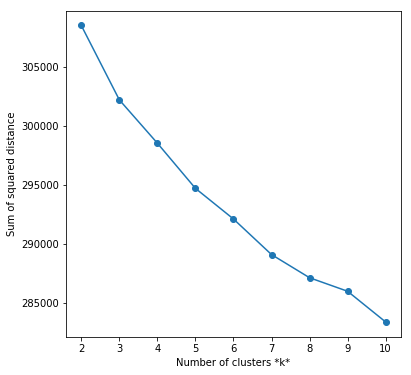

In [133]:
plt.figure(figsize=(6, 6))
plt.plot(lst_k, squared_error_bow, '-o')
plt.xlabel('Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [210]:
km_bow = KMeans(n_clusters=9,n_jobs =-1)
km_bow.fit(sample_bow)
#km.predict(sample_bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [123]:
df = pd.DataFrame(sample["Summary"]) 

In [124]:
df.head()

Summary
17722   Bold and delicious
176264  Cafe Santo Domingo
60285     These are a miss
76864    Delicious coffee!
114412           The best!

In [126]:
print(km_bow.labels_)

[2 0 0 ... 0 4 0]


In [88]:
type(sample)

pandas.core.frame.DataFrame

In [212]:
print(pd.value_counts(sample['Bow Clusters'].values, sort=False))

0      36
4       1
8      59
1     631
5       6
2    3991
6       4
3      79
7     193
dtype: int64


In [213]:
df = pd.DataFrame(pd.value_counts(sample['Bow Clusters'].values, sort=False))
df.head()

0
0   36
4    1
8   59
1  631
5    6

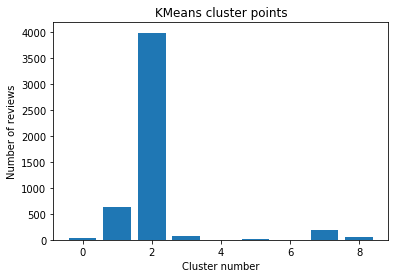

In [214]:
plt.bar(df.index,df[0])
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of reviews")
plt.show()

Cluster 0:


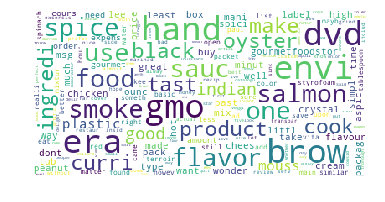

In [184]:
order_centroids = km_bow.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
cloud = ''
print("Cluster %d:" % 0)
for ind in order_centroids[0, :3599]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- In this cluster most of the words describes about food products.

Cluster 1:


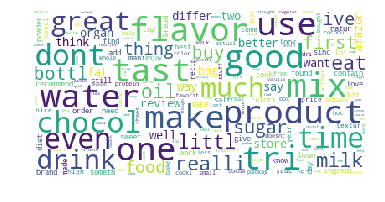

In [185]:
cloud = ''
print("Cluster %d:" % 1)
for ind in order_centroids[1, :193]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- In this cluster most words describes about food products of type liquid.

Cluster 2:


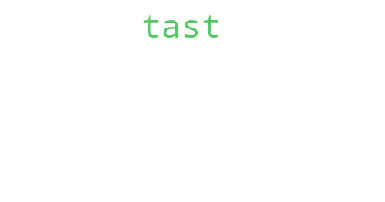

In [190]:
cloud = ''
print("Cluster %d:" % 2)
for ind in `:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(2)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Cluster 3:


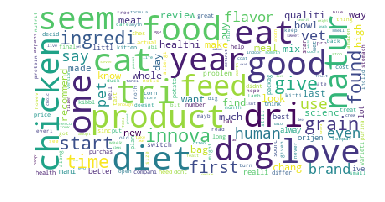

In [191]:
cloud = ''
print("Cluster %d:" % 3)
for ind in order_centroids[3, :583]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- In this cluster most words describes about animal food.

Cluster 4:


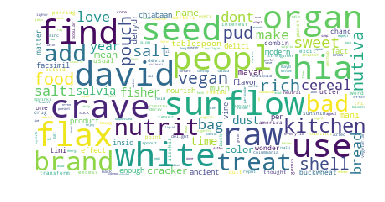

In [192]:
cloud = ''
print("Cluster %d:" % 4)
for ind in order_centroids[4, :493]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(4)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- In this cluster most of the words describs about oils and wheat products.

Cluster 5:


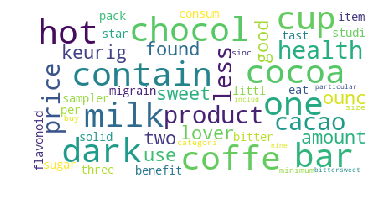

In [193]:
cloud = ''
print("Cluster %d:" % 5)
for ind in order_centroids[5, :52]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(5)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- In this cluster most of the words are related to coffee products.

Cluster 6:


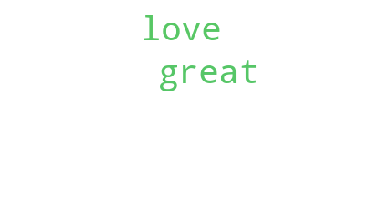

In [194]:
cloud = ''
print("Cluster %d:" % 6)
for ind in order_centroids[6, :2]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(6)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Cluster 7:


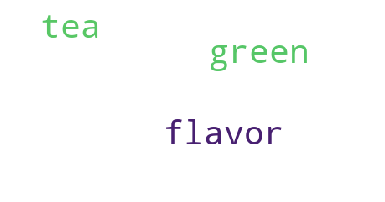

In [195]:
cloud = ''
print("Cluster %d:" % 7)
for ind in order_centroids[7, :3]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(7)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Cluster 8:


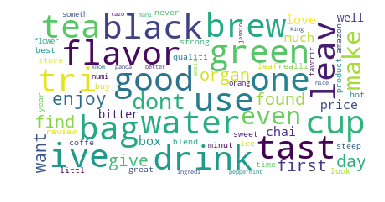

In [196]:
cloud = ''
print("Cluster %d:" % 8)
for ind in order_centroids[8, :77]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(8)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- In this cluster most of the words related to tea products.

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [232]:
squared_error_tfidf = []
#list_k = list(range(1, 10))
lst_k =[]

for k in tqdm(range(2,11)):
    km = KMeans(n_clusters=k,n_jobs =-1)
    km.fit(sample_tfidf)
    squared_error_tfidf.append(km.inertia_)
    lst_k.append(k)
# Plot sse against k



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [11:34<00:00, 86.37s/it]


In [100]:
print(squared_error_tfidf)

[9705.307789948714, 9639.941227843652, 9588.32546049337, 9549.029932382831, 9518.583763279672, 9493.533322137288, 9469.092682057877, 9443.914650535744, 9421.892448344124, 9406.089020103747, 9396.555133363014, 9378.93864894322, 9360.094227206897, 9349.069532179037, 9329.741832620066, 9309.751980474846, 9297.206210834212, 9288.909295107436]


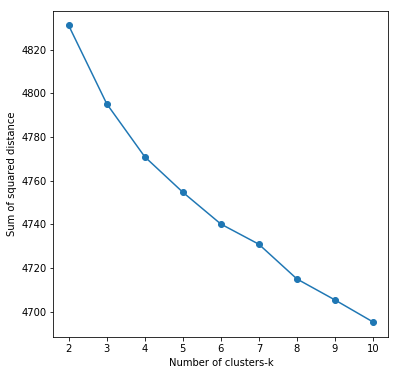

In [233]:
plt.figure(figsize=(6, 6))
plt.plot(lst_k, squared_error_tfidf, '-o')
plt.xlabel('Number of clusters-k')
plt.ylabel('Sum of squared distance')
plt.show()

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [234]:
km_tfidf = KMeans(n_clusters=8,n_jobs =-1)
km_tfidf.fit(sample_tfidf)
#km.predict(sample_bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

0     123
4     413
1     697
5    1429
2    1497
6     275
3     325
7     241
dtype: int64


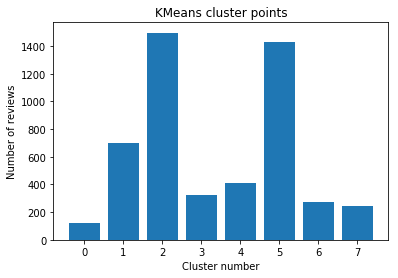

In [235]:
#df = sample_data
sample['tfidf Clusters'] = km_tfidf.labels_
sample.head(6)

type(sample)

print(pd.value_counts(sample['tfidf Clusters'].values, sort=False))

df = pd.DataFrame(pd.value_counts(sample['tfidf Clusters'].values, sort=False))
df.head()

plt.bar(df.index,df[0])
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of reviews")
plt.show()

In [236]:
order_centroids = km_tfidf.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vect.get_feature_names()

Cluster 0:


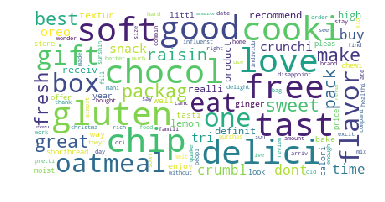

In [237]:

#for i in range(18):
cloud = ''
print("Cluster %d:" % 0)
for ind in order_centroids[0, :123]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- The words in this cluster describes about breakfast products.

Cluster 1:


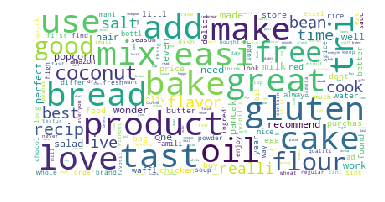

In [238]:
cloud = ''
print("Cluster %d:" % 1)
for ind in order_centroids[1, :697]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Words in this cluster describes about wheat products

Cluster 2:


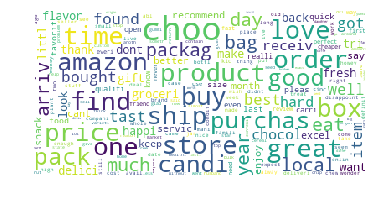

In [239]:
cloud = ''
print("Cluster %d:" % 2)
for ind in order_centroids[2, :1497]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(2)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observarion:
- This cluster describs about shopping.

Cluster 3:


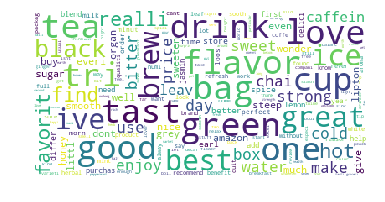

In [240]:
cloud = ''
print("Cluster %d:" % 3)
for ind in order_centroids[3, :325]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(3)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- This cluster describes about tea.

Cluster 4:


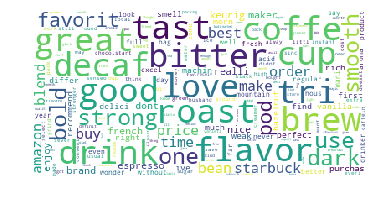

In [241]:
cloud = ''
print("Cluster %d:" % 4)
for ind in order_centroids[4, :413]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(4)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- This cluster describes about coffee.

Cluster 5:


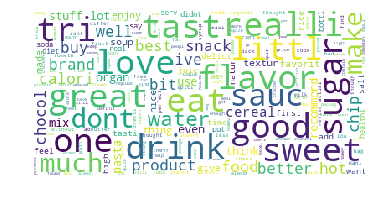

In [242]:
cloud = ''
print("Cluster %d:" % 5)
for ind in order_centroids[5, :1429]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(5)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- This cluster describes about Taste.

Cluster 6:


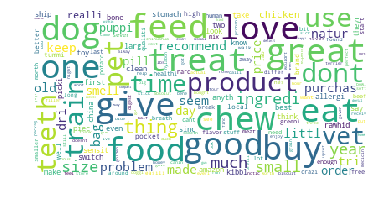

In [243]:
cloud = ''
print("Cluster %d:" % 6)
for ind in order_centroids[6, :275]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(6)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- This cluster describes about animal feed.

Cluster 7:


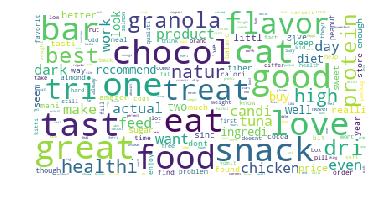

In [244]:
cloud = ''
print("Cluster %d:" % 7)
for ind in order_centroids[7, :241]:
    cloud = cloud + " " + terms[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(7)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- This cluster describs about some snaks and protein food.

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [308]:
squared_distance_avgw2v = []
#list_k = list(range(1, 10))
lst_k =[]

for k in tqdm(range(2,11)):
    km = KMeans(n_clusters=k,n_jobs =-1)
    km.fit(sent_vectors)
    squared_distance_avgw2v.append(km.inertia_)
    lst_k.append(k)
# Plot sse against k


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.73s/it]


In [309]:
print(squared_distance_avgw2v)

[1026.6397623103678, 780.7840469497777, 657.6904378732013, 577.2524153424536, 514.3962477122222, 475.1722967362279, 439.95928733966855, 407.84897859886877, 386.898565196549]


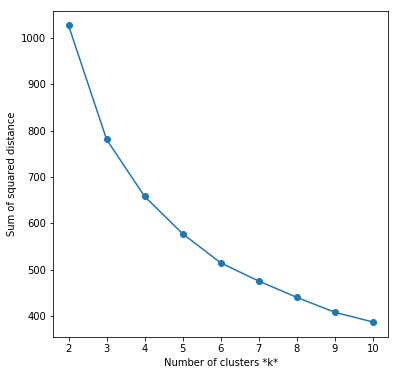

In [310]:
plt.figure(figsize=(6, 6))
plt.plot(lst_k, squared_distance_avgw2v, '-o')
plt.xlabel('Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [314]:
km_avg_w2v = KMeans(n_clusters=6,n_jobs =-1)
km_avg_w2v.fit(sent_vectors)
#km.predict(sample_bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Cluster 0:


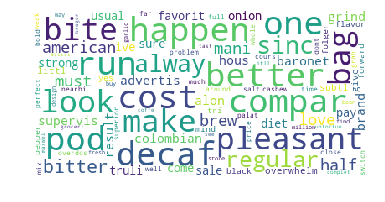

In [366]:
#order_centroids = km_avg_w2v.cluster_centers_.argsort()[:, ::-1]
#terms = tf_idf_vect.get_feature_names()
#for i in range(22):
cloud = ''
print("Cluster %d:" % 0)
for ind in order_centroids[0,:]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- This cluster describes about taste. 

Cluster 1:


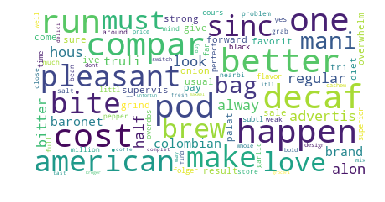

In [367]:
cloud = ''
print("Cluster %d:" % 1)
for ind in order_centroids[1,:]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- This cluster describes about taste related to specific region.

Cluster 2:


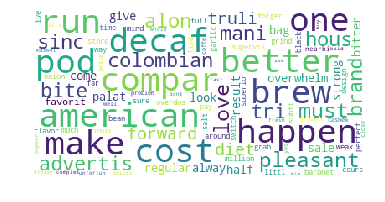

In [368]:
cloud = ''
print("Cluster %d:" % 2)
for ind in order_centroids[2, :]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Obsevation:
- This cluster describes about countries based products.

Cluster 3:


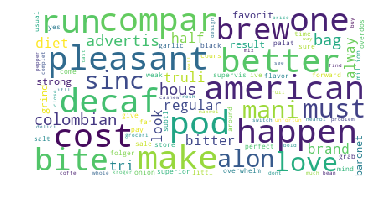

In [369]:
cloud = ''
print("Cluster %d:" % 3)
for ind in order_centroids[3, :]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(3)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- This cluster describs about taste of american products.

Cluster 4:


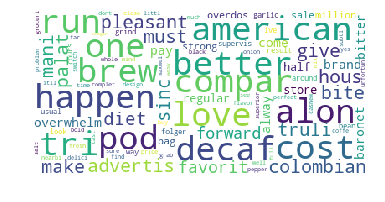

In [370]:
cloud = ''
print("Cluster %d:" % 4)
for ind in order_centroids[4, :]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(4)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Cluster-3 and cluster-4 has most common words.

Cluster 5:


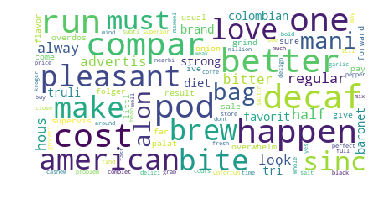

In [371]:
cloud = ''
print("Cluster %d:" % 5)
for ind in order_centroids[5, :]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(5)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- The clustering using avg_w2v in not usefull. since, all the clusters are looking very similar.

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [333]:
squared_distance_tfidfw2v = []
#list_k = list(range(1, 10))
lst_k =[]

for k in tqdm(range(2,11)):
    km = KMeans(n_clusters=k,n_jobs =-1)
    km.fit(tfidf_w2v_sample)
    squared_distance_tfidfw2v.append(km.inertia_)
    lst_k.append(k)
# Plot sse against k



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:34<00:00,  4.02s/it]


In [334]:
print(squared_distance_tfidfw2v)

[1680.256694369655, 1164.4675024257801, 974.3159299142045, 850.2452540740599, 751.5367524368247, 665.0320434380226, 602.9241779431712, 564.7737906349269, 525.3617274227057]


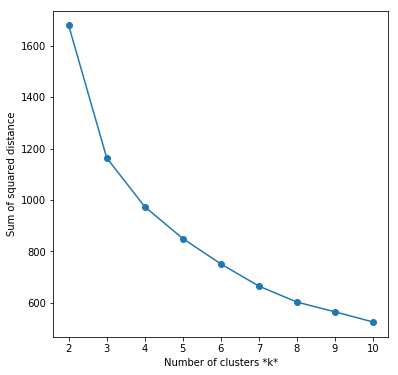

In [335]:
plt.figure(figsize=(6, 6))
plt.plot(lst_k, squared_distance_tfidfw2v, '-o')
plt.xlabel('Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [336]:
km_tfidf_w2v = KMeans(n_clusters=7,n_jobs =-1)
km_tfidf_w2v.fit(tfidf_w2v_sample)
#km.predict(sample_bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Cluster 0:


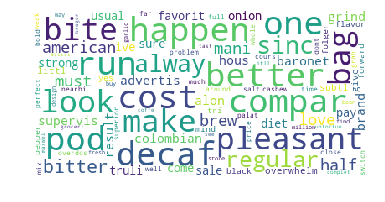

In [358]:
order_centroids = km_tfidf_w2v.cluster_centers_.argsort()[:, ::-1]
terms = model.get_feature_names()
#for i in range(22):
cloud = ''
print("Cluster %d:" % i)
for ind in order_centroids[0,:]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(i)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Cluster 1:


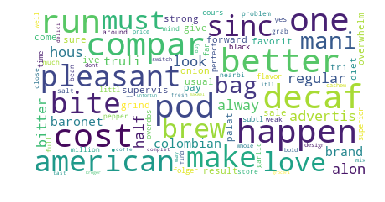

In [359]:
order_centroids = km_tfidf_w2v.cluster_centers_.argsort()[:, ::-1]
terms = model.get_feature_names()
#for i in range(22):
cloud = ''
print("Cluster %d:" % 1)
for ind in order_centroids[1,:]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
#fig = plt.figure(i)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Cluster 2:


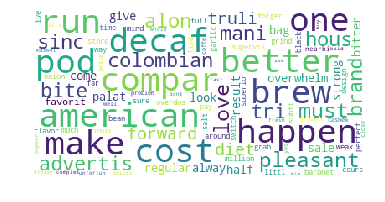

In [360]:
order_centroids = km_tfidf_w2v.cluster_centers_.argsort()[:, ::-1]
terms = model.get_feature_names()
#for i in range(22):
cloud = ''
print("Cluster %d:" % 2)
for ind in order_centroids[2,:]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
#fig = plt.figure(i)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Cluster 3:


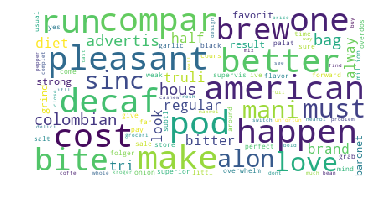

In [361]:
order_centroids = km_tfidf_w2v.cluster_centers_.argsort()[:, ::-1]
terms = model.get_feature_names()
#for i in range(22):
cloud = ''
print("Cluster %d:" % 3)
for ind in order_centroids[3,:]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
#fig = plt.figure(i)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Cluster 4:


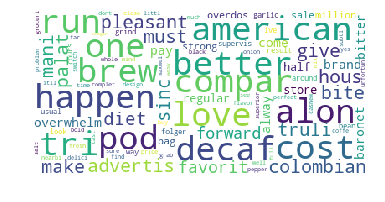

In [362]:
order_centroids = km_tfidf_w2v.cluster_centers_.argsort()[:, ::-1]
terms = model.get_feature_names()
#for i in range(22):
cloud = ''
print("Cluster %d:" % 4)
for ind in order_centroids[4,:]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(i)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Cluster 5:


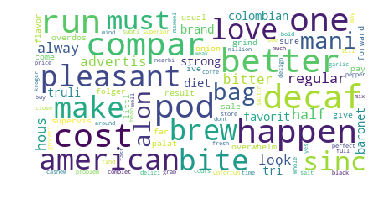

In [363]:
order_centroids = km_tfidf_w2v.cluster_centers_.argsort()[:, ::-1]
terms = model.get_feature_names()
#for i in range(22):
cloud = ''
print("Cluster %d:" % 5)
for ind in order_centroids[5,:]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(5)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Cluster 6:


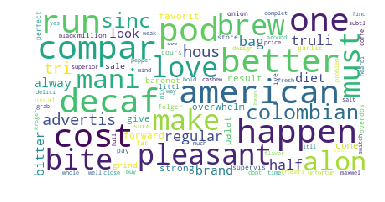

In [392]:
order_centroids = km_tfidf_w2v.cluster_centers_.argsort()[:, ::-1]
terms = model.get_feature_names()
#for i in range(22):
cloud = ''
print("Cluster %d:" % 6)
for ind in order_centroids[6,:]:
    cloud = cloud + " " + sample_w2v_words[ind]
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cloud)

#print(wordcloud)
fig = plt.figure(i)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Seems like even tfidf_w2v is also not working well with KMeans clustering

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [372]:
from sklearn.cluster import AgglomerativeClustering

In [373]:
agg_avg_w2v = AgglomerativeClustering(n_clusters=2)
agg_avg_w2v.fit(sent_vectors)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000001F077E90510>)

In [432]:
cluster1=''
cluster2=''
for i in range(2500):
    if(agg_avg_w2v.labels_[i]==0):
        cluster1 = cluster1 +" "+ sample_w2v_words[i]
    if(agg_avg_w2v.labels_[i]==1):
        cluster2 = cluster2 +" "+ sample_w2v_words[i]

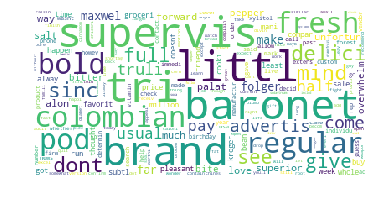

In [434]:
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

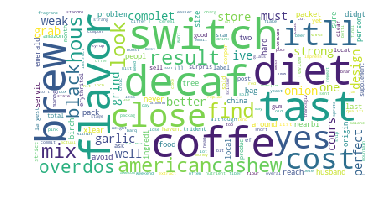

In [435]:
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster2)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Cluster-1 seems tobe too difficult to interpret the clusters.
- But cluster-2 seems to be describing about snaks with evening coffee. 

In [374]:
agg_avg_w2v_3 = AgglomerativeClustering(n_clusters=3)
agg_avg_w2v_3.fit(sent_vectors)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x000001F077E90510>)

cluster1:


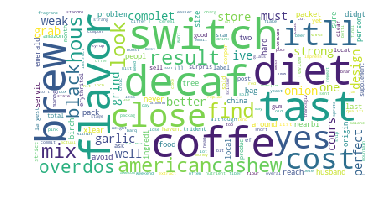

cluster2


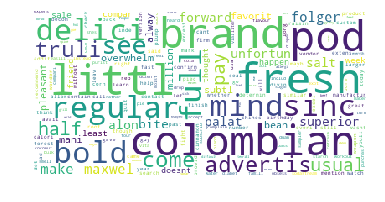

cluster3


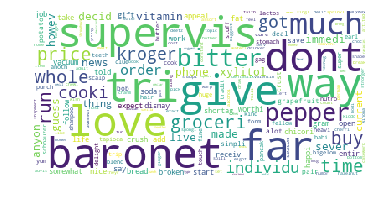

In [439]:
cluster1=''
cluster2=''
cluster3=''
for i in range(3000):
    if(agg_avg_w2v_3.labels_[i]==0):
        cluster1 = cluster1 +" "+ sample_w2v_words[i]
    if(agg_avg_w2v_3.labels_[i]==1):
        cluster2 = cluster2 +" "+ sample_w2v_words[i]
    if(agg_avg_w2v_3.labels_[i]==2):
        cluster3 = cluster3 +" "+ sample_w2v_words[i]

print("cluster1:")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster1)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster2")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster2)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster3")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster3)
fig = plt.figure(2)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Cluster-1 describes coffee with snaks for healthy diet.
- Cluster-2 describes about the food brands.
- Cluster-3 seems tobe too hard to interpret. So it is better to incresses the no.of clusters. 

In [375]:
agg_avg_w2v_5 = AgglomerativeClustering(n_clusters=5)
agg_avg_w2v_5.fit(sent_vectors)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x000001F077E90510>)

cluster1:


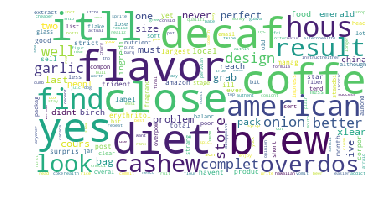

cluster2


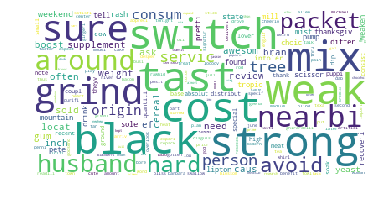

cluster3


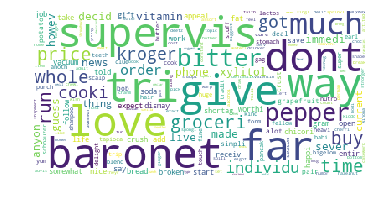

cluster4


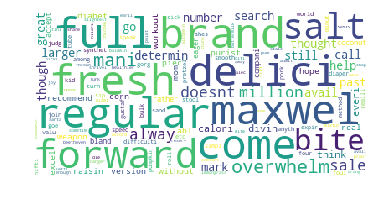

cluster5


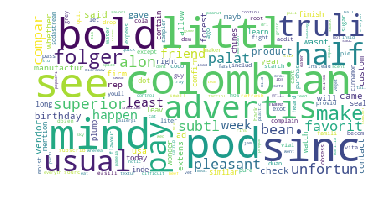

In [441]:
cluster1=''
cluster2=''
cluster3=''
cluster4=''
cluster5=''
for i in range(3000):
    if(agg_avg_w2v_5.labels_[i]==0):
        cluster1 = cluster1 +" "+ sample_w2v_words[i]
    if(agg_avg_w2v_5.labels_[i]==1):
        cluster2 = cluster2 +" "+ sample_w2v_words[i]
    if(agg_avg_w2v_5.labels_[i]==2):
        cluster3 = cluster3 +" "+ sample_w2v_words[i]
    if(agg_avg_w2v_5.labels_[i]==3):
        cluster4 = cluster4 +" "+ sample_w2v_words[i]
    if(agg_avg_w2v_5.labels_[i]==4):
        cluster5 = cluster5 +" "+ sample_w2v_words[i]

print("cluster1:")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster1)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster2")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster2)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster3")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster3)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(2)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster4")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster4)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(4)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster5")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster5)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(5)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Cluster-1 describes about the coffee and snaks.
- Cluster-2 describes about the shopping experience.
- Cluster-3 describes about the spices.
- Cluster-4 desctibes taste of the products.
- Cluster-5 describes about the shape of the products.

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [452]:
agg_tfidf_w2v = AgglomerativeClustering(n_clusters=2)
agg_tfidf_w2v.fit(tfidf_w2v_sample)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000001F077E90510>)

In [456]:
agg_tfidf_w2v3 = AgglomerativeClustering(n_clusters=3)
agg_tfidf_w2v3.fit(tfidf_w2v_sample)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x000001F077E90510>)

In [457]:
agg_tfidf_w2v5 = AgglomerativeClustering(n_clusters=5)
agg_tfidf_w2v5.fit(tfidf_w2v_sample)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x000001F077E90510>)

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

cluster1:


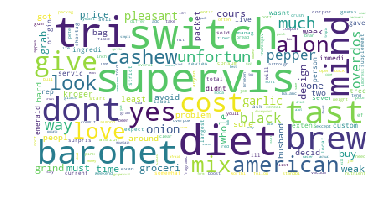

cluster2


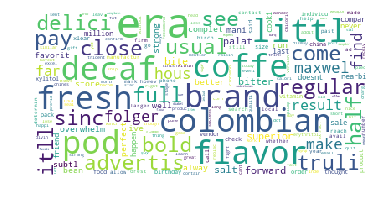

In [459]:
cluster1=''
cluster2=''
#cluster3=''
for i in range(2500):
    if(agg_tfidf_w2v.labels_[i]==0):
        cluster1 = cluster1 +" "+ sample_w2v_words[i]
    if(agg_tfidf_w2v.labels_[i]==1):
        cluster2 = cluster2 +" "+ sample_w2v_words[i]

print("cluster1:")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster1)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster2")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster2)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Cluster-1 describes about taste of dryfruits.
- Cluster-2 describes about flavors of colombian brands.

cluster1:


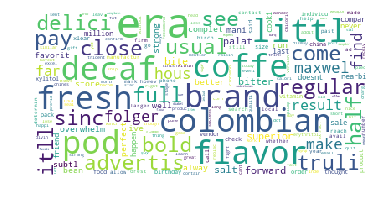

cluster2


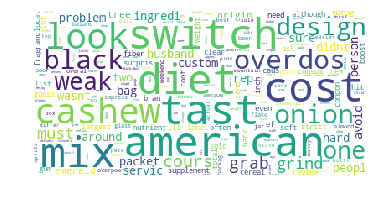

cluster3


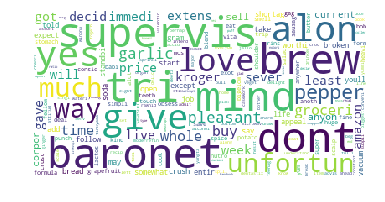

In [460]:
cluster1=''
cluster2=''
cluster3=''
for i in range(3000):
    if(agg_tfidf_w2v3.labels_[i]==0):
        cluster1 = cluster1 +" "+ sample_w2v_words[i]
    if(agg_tfidf_w2v3.labels_[i]==1):
        cluster2 = cluster2 +" "+ sample_w2v_words[i]
    if(agg_tfidf_w2v3.labels_[i]==2):
        cluster3 = cluster3 +" "+ sample_w2v_words[i]

print("cluster1:")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster1)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster2")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster2)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster3")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster3)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(2)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Cluster-1 describes about the taste of colombian brands.
- Cluster-2 describes about the taste of american brands.
- Cluster-3 describes about the products related to spices.

cluster1:


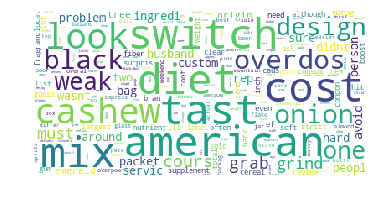

cluster2


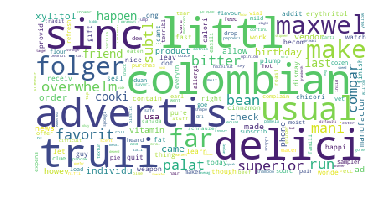

cluster3


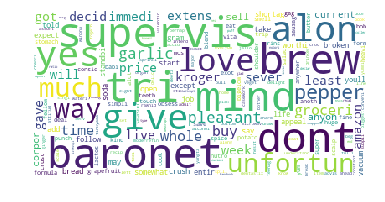

cluster4


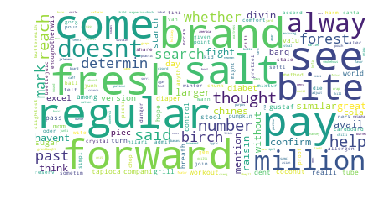

cluster5


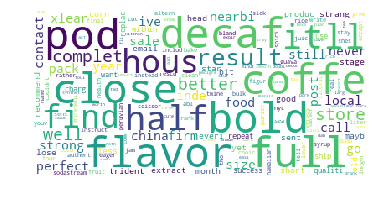

In [461]:
cluster1=''
cluster2=''
cluster3=''
cluster4=''
cluster5=''
for i in range(3000):
    if(agg_tfidf_w2v5.labels_[i]==0):
        cluster1 = cluster1 +" "+ sample_w2v_words[i]
    if(agg_tfidf_w2v5.labels_[i]==1):
        cluster2 = cluster2 +" "+ sample_w2v_words[i]
    if(agg_tfidf_w2v5.labels_[i]==2):
        cluster3 = cluster3 +" "+ sample_w2v_words[i]
    if(agg_tfidf_w2v5.labels_[i]==3):
        cluster4 = cluster4 +" "+ sample_w2v_words[i]
    if(agg_tfidf_w2v5.labels_[i]==4):
        cluster5 = cluster5 +" "+ sample_w2v_words[i]

print("cluster1:")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster1)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster2")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster2)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster3")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster3)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(2)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster4")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster4)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(4)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster5")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster5)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(5)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Cluster-1 describes about taste of american products.
- Cluster-2 describes about taste of colombian products.
- Cluster-3 describes the products related to spices.
- Cluster-4 describes quality.
- Cluster-5 describes the taste of coffee.

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [492]:
minPts = 100
#https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # returns the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def nearestneighbour(x, vect): # returns the distance of nearest neighbour.
    distances = []
    for val in vect:
        distance = np.sum((x - val) **2 ) # computing the distances.
        if(len(distances) == 100 and distances[99] > distance): # if distance is larger than current largest distance found.
            lower = int(lower_bound(distances, distance)) # using the lower bound function to get the right position.
            if (lower < 100) and (lower >= 0) and (distances[lower] > distance):
                distances[lower] = distance
        else:
            distances.append(distance)
            distances.sort()
    
    return distances[99] 

In [493]:
neighbours = []
for val in sent_vectors[:1000]:
    neighbours.append(nearestneighbour(val, sent_vectors[:1000]) )
neighbours.sort()

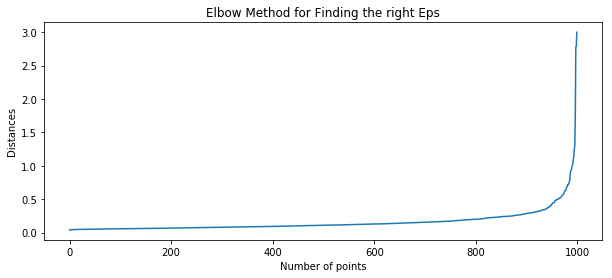

In [494]:

plt.figure(figsize=(10,4))
plt.title("Elbow Method for Finding the right Eps")
plt.plot([x for x in range(len(neighbours))], neighbours)
plt.xlabel("Number of points")
plt.ylabel("Distances")
plt.show()

In [512]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps = 0.5, min_samples = 100, n_jobs=-1)
model.fit(sent_vectors)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

In [513]:
import collections
print(collections.Counter(model.labels_))

Counter({0: 4989, -1: 11})


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

cluster1:


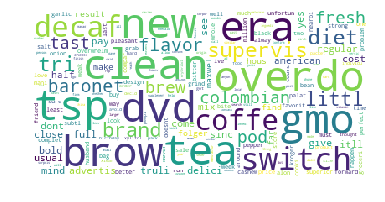

cluster2


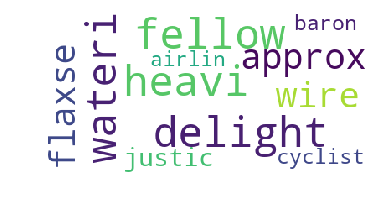

In [514]:
cluster1=''
cluster2=''
#cluster3=''
for i in range(5000):
    if(model.labels_[i]==0):
        cluster1 = cluster1 +" "+ sample_w2v_words[i]
    if(model.labels_[i]==(-1)):
        cluster2 = cluster2 +" "+ sample_w2v_words[i]
#    if(agg_avg_w2v_3.labels_[i]==2):
#        cluster3 = cluster3 +" "+ sample_w2v_words[i]

print("cluster1:")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster1)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster2")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster2)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#print("cluster3")
#wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster3)
#wc = wordcloud.

#print(wordcloud)
#fig = plt.figure(2)
#plt.imshow(wordcloud)
#plt.axis('off')
#plt.show()

#### Observation:
- Cluster-1 describes food products.
- Cluster-2 describes type of food.

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [508]:
neighbours = []
for val in sent_vectors[:1000]:
    neighbours.append(nearestneighbour(val, tfidf_w2v_sample[:1000]) )
neighbours.sort()

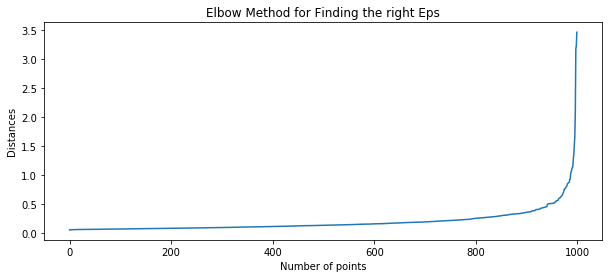

In [509]:
plt.figure(figsize=(10,4))
plt.title("Elbow Method for Finding the right Eps")
plt.plot([x for x in range(len(neighbours))], neighbours)
plt.xlabel("Number of points")
plt.ylabel("Distances")
plt.show()

In [515]:
model = DBSCAN(eps = 0.5, min_samples = 100, n_jobs=-1)
model.fit(tfidf_w2v_sample)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

In [516]:
print(collections.Counter(model.labels_))

Counter({0: 4955, -1: 45})


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

cluster1:


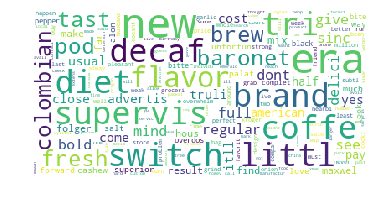

cluster2


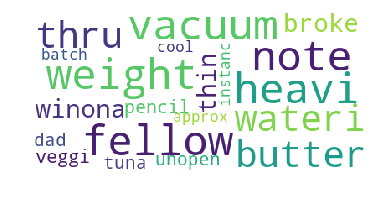

In [517]:
cluster1=''
cluster2=''
#cluster3=''
for i in range(2500):
    if(model.labels_[i]==0):
        cluster1 = cluster1 +" "+ sample_w2v_words[i]
    if(model.labels_[i]==(-1)):
        cluster2 = cluster2 +" "+ sample_w2v_words[i]
#    if(agg_avg_w2v_3.labels_[i]==2):
#        cluster3 = cluster3 +" "+ sample_w2v_words[i]

print("cluster1:")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster1)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(0)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("cluster2")
wordcloud = WordCloud(background_color='white',max_font_size=50, random_state=42).generate(cluster2)
#wc = wordcloud.

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation:
- Cluster-1 describes products and their taste.
- Cluster-2 describes the type and the shape of products.

# [6] Conclusions

    ********************************************************************************************
    *  clustering algorithm   |     featurization    |    no.of clusters   |   hyperparameter  *
    ********************************************************************************************
    *                         |         BoW          |          9          |       k=9         *
    *                         |*****************************************************************
    *                         |        tfidf         |          8          |       k=8         *
    *        K-means          |*****************************************************************
    *                         |       avg_w2v        |          6          |       k=6         *
    *                         |*****************************************************************
    *                         |      tfidf_w2v       |          7          |       k=7         *
    ********************************************************************************************
    *                         |       avg_w2v        |          5          |        -          *
    *     agglomerative       |*****************************************************************
    *                         |      tfidf_w2v       |          5          |        -          *
    ********************************************************************************************
    *                         |       avg_w2v        |          2          |      eps=0.5      *
    *         DBSCAN          |*****************************************************************
    *                         |      tfidf_w2v       |          3          |      eps=0.5      *
    ********************************************************************************************